In [1]:
#List of imports

import networkx as nx
import numpy as np
import pickle
from pathlib import Path
import os
import torch
import time
import dgl
import WLColorRefinement as wl
import CSL_data


Using backend: pytorch


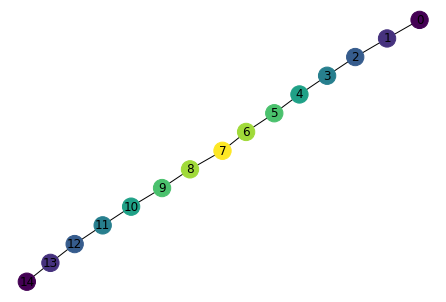

In [18]:
#Get the CSL graphs
CSL_graphs = CSL_data.get_CSL_graphs()

G = nx.path_graph(15)
mapping = {i: j for i, j in zip(
    range(10), np.random.permutation(range(10)))}
H = nx.relabel_nodes(G, mapping)

G = dgl.from_networkx(G)
H = dgl.from_networkx(H)

wl.is_possibly_isomorphic(G,H)

# for i in CSL_graphs:
#     wl.is_possibly_isomorphic(i) # True

"""
    Funtion to draw the graph
"""
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=G.ndata['color'] )

In [19]:
"""
    Function to create a supernode
    The idea is to have a function that iterates over the graph
    finds the nodes with the same colors and then places them in one supernode

    Input - dglGraph with colored nodes
    Output - dglGraph with supernodes
"""

super_node = {}
colors = G.ndata['color'].numpy()
count = 0
for color in colors:
    print (color)
    if color not in super_node:
        super_node[color]=list()
    super_node[color].append(count)
    count=count+1

52
53
54
55
56
57
58
59
58
57
56
55
54
53
52


In [20]:
"""
    Function to find the edges between supernodes and calculate the weight of the edges.
    The weight of the edge is the total of edges that go from one node within the supernode to another node in another supernode.
    If the number of edges from each node going out are not the same, the smallest common value is taken.
    
    Input - dglGraph with colored nodes
Output - dglGraph with supernodes
"""

{52: [0, 14], 53: [1, 13], 54: [2, 12], 55: [3, 11], 56: [4, 10], 57: [5, 9], 58: [6, 8], 59: [7]}
